# Modelo XGBoost para Predicción de Potencia en Granjas Undimotrices

Este notebook implementa el modelo completo:
- Preprocesamiento de datos
- Ordenamiento canónico (solución a invarianza de permutación)
- Ingeniería de características
- Entrenamiento de XGBoost
- Evaluación y métricas


In [1]:
# Importaciones
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pickle
from datetime import datetime

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb

warnings.filterwarnings('ignore')

# Configuración
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Directorios
DATASET_DIR = Path("dataset")
MODELS_DIR = Path("models")
MODELS_DIR.mkdir(exist_ok=True)

print("Librerías importadas correctamente")


Librerías importadas correctamente


## 1. Clase de Ingeniería de Características


In [2]:
class FeatureEngineer:
    """Clase para ingeniería de características con ordenamiento canónico."""

    def __init__(self, n_converters):
        self.n_converters = n_converters

    def canonical_ordering(self, coordinates):
        """
        Ordenamiento canónico: ordenar por X (ascendente), luego Y (ascendente).
        Resuelve el problema de invarianza de permutación.

        Args:
            coordinates: array de shape (n_samples, n_converters, 2) con [X, Y]

        Returns:
            coordinates_ordered: coordenadas ordenadas canónicamente
        """
        n_samples = coordinates.shape[0]
        coordinates_ordered = np.zeros_like(coordinates)

        for i in range(n_samples):
            coords = coordinates[i].copy()
            # Ordenar lexicográficamente: primero por X, luego por Y
            sort_indices = np.lexsort((coords[:, 1], coords[:, 0]))
            coordinates_ordered[i] = coords[sort_indices]

        return coordinates_ordered

    def extract_coordinates(self, df):
        """Extrae coordenadas X, Y del dataframe."""
        x_cols = [f'X{i+1}' for i in range(self.n_converters)]
        y_cols = [f'Y{i+1}' for i in range(self.n_converters)]

        x_values = df[x_cols].values
        y_values = df[y_cols].values

        # Reshape a (n_samples, n_converters, 2)
        coordinates = np.stack([x_values, y_values], axis=2)
        return coordinates

    def compute_centroid(self, coordinates):
        """Calcula el centroide de cada configuración."""
        return coordinates.mean(axis=1)

    def compute_distances_to_centroid(self, coordinates, centroids):
        """Calcula distancia de cada WEC al centroide."""
        n_samples = coordinates.shape[0]
        distances = np.zeros((n_samples, self.n_converters))

        for i in range(n_samples):
            centroid = centroids[i]
            coords = coordinates[i]
            distances[i] = np.sqrt(np.sum((coords - centroid)**2, axis=1))

        return distances

    def compute_neighbor_distances(self, coordinates, k=3):
        """Calcula distancia a los k vecinos más cercanos."""
        n_samples = coordinates.shape[0]
        min_distances = np.zeros((n_samples, self.n_converters))
        mean_distances = np.zeros((n_samples, self.n_converters))

        for i in range(n_samples):
            coords = coordinates[i]

            for j in range(self.n_converters):
                distances = np.sqrt(np.sum((coords - coords[j])**2, axis=1))
                distances[j] = np.inf  # Excluir distancia a sí mismo

                k_nearest = np.partition(distances, min(k, len(distances)-1))[:k+1]
                k_nearest = k_nearest[k_nearest != np.inf]

                if len(k_nearest) > 0:
                    min_distances[i, j] = np.min(k_nearest)
                    mean_distances[i, j] = np.mean(k_nearest[:k])

        return min_distances, mean_distances

    def compute_spatial_metrics(self, coordinates):
        """Calcula métricas de dispersión espacial."""
        n_samples = coordinates.shape[0]
        metrics = {
            'max_distance': np.zeros(n_samples),
            'min_distance': np.zeros(n_samples),
            'mean_distance': np.zeros(n_samples),
            'std_distance': np.zeros(n_samples)
        }

        for i in range(n_samples):
            coords = coordinates[i]
            distances = []
            for j in range(self.n_converters):
                for k in range(j+1, self.n_converters):
                    dist = np.linalg.norm(coords[j] - coords[k])
                    distances.append(dist)

            if distances:
                distances = np.array(distances)
                metrics['max_distance'][i] = np.max(distances)
                metrics['min_distance'][i] = np.min(distances)
                metrics['mean_distance'][i] = np.mean(distances)
                metrics['std_distance'][i] = np.std(distances)

        return metrics

    def transform(self, df):
        """
        Transforma el dataframe aplicando todas las transformaciones.

        Returns:
            X: array de features (n_samples, n_features)
            y: array de target (n_samples,)
            feature_names: lista de nombres de features
        """
        # Extraer coordenadas
        coordinates = self.extract_coordinates(df)

        # Aplicar ordenamiento canónico (CRÍTICO)
        coordinates = self.canonical_ordering(coordinates)

        # Aplanar coordenadas ordenadas
        n_samples = coordinates.shape[0]
        X_coords = coordinates.reshape(n_samples, -1)

        # Nombres de features de coordenadas
        coord_feature_names = []
        for i in range(self.n_converters):
            coord_feature_names.append(f'X{i+1}_ordered')
            coord_feature_names.append(f'Y{i+1}_ordered')

        X_list = [X_coords]
        feature_names_list = [coord_feature_names]

        # Features de ingeniería
        centroids = self.compute_centroid(coordinates)
        dist_to_centroid = self.compute_distances_to_centroid(coordinates, centroids)
        min_dist, mean_dist = self.compute_neighbor_distances(coordinates, k=3)
        spatial_metrics = self.compute_spatial_metrics(coordinates)

        X_list.extend([
            dist_to_centroid,
            min_dist,
            mean_dist,
            np.column_stack([
                spatial_metrics['max_distance'],
                spatial_metrics['min_distance'],
                spatial_metrics['mean_distance'],
                spatial_metrics['std_distance']
            ])
        ])

        feature_names_list.extend([
            [f'dist_centroid_{i+1}' for i in range(self.n_converters)],
            [f'min_dist_neighbor_{i+1}' for i in range(self.n_converters)],
            [f'mean_dist_neighbor_{i+1}' for i in range(self.n_converters)],
            ['max_distance', 'min_distance', 'mean_distance', 'std_distance']
        ])

        # Concatenar todas las features
        X = np.hstack(X_list)
        feature_names = [name for sublist in feature_names_list for name in sublist]

        # Extraer target
        y = df['Total_Power'].values

        return X, y, feature_names

print("Clase FeatureEngineer definida")



Clase FeatureEngineer definida


## 2. Carga y Preprocesamiento de Datos


In [3]:
# Configuración del dataset a procesar
DATASET_NAME = "perth_100"# Cambiar a "sydney_49", "perth_100", "sydney_100"según necesidad

# Mapeo de nombres a archivos
dataset_files = {
 "perth_49": "WEC_Perth_49.csv",
 "perth_100": "WEC_Perth_100.csv",
 "sydney_49": "WEC_Sydney_49.csv",
 "sydney_100": "WEC_Sydney_100.csv"
}
DATASET_FILE = DATASET_DIR / dataset_files[DATASET_NAME]

# Determinar número de convertidores
if "49"in DATASET_NAME:
 N_CONVERTERS = 49
else:
 N_CONVERTERS = 100

print(f"Dataset: {DATASET_NAME}")
print(f"Archivo: {DATASET_FILE}")
print(f"Convertidores: {N_CONVERTERS}")

# Cargar datos
df = pd.read_csv(DATASET_FILE)
print(f"Datos cargados: {len(df):,} filas × {len(df.columns)} columnas")

# Eliminar duplicados
df_original = len(df)
df = df.drop_duplicates()
print(f"Duplicados eliminados: {df_original - len(df):,} filas")
print(f"Filas únicas: {len(df):,}")


Dataset: perth_100
Archivo: dataset\WEC_Perth_100.csv
Convertidores: 100
Datos cargados: 7,277 filas × 302 columnas
Duplicados eliminados: 4,540 filas
Filas únicas: 2,737


In [4]:
# Aplicar ingeniería de características
fe = FeatureEngineer(N_CONVERTERS)
X, y, feature_names = fe.transform(df)

print(f"Ingeniería de características completada")
print(f"Features generadas: {len(feature_names)}")
print(f"Shape: X={X.shape}, y={y.shape}")
print(f"Primeras 10 features: {feature_names[:10]}")
print(f"Últimas 5 features: {feature_names[-5:]}")

# Estadísticas
print(f"Estadísticas de X:")
print(f"Min: {X.min():.2f}, Max: {X.max():.2f}")
print(f"Mean: {X.mean():.2f}, Std: {X.std():.2f}")
print(f"Estadísticas de y (Total_Power):")
print(f"Min: {y.min():.2f}, Max: {y.max():.2f}")
print(f"Mean: {y.mean():.2f}, Std: {y.std():.2f}")


Ingeniería de características completada
Features generadas: 504
Shape: X=(2737, 504), y=(2737,)
Primeras 10 features: ['X1_ordered', 'Y1_ordered', 'X2_ordered', 'Y2_ordered', 'X3_ordered', 'Y3_ordered', 'X4_ordered', 'Y4_ordered', 'X5_ordered', 'Y5_ordered']
Últimas 5 features: ['mean_dist_neighbor_100', 'max_distance', 'min_distance', 'mean_distance', 'std_distance']
Estadísticas de X:
Min: 0.00, Max: 2050.61
Mean: 425.96, Std: 396.50
Estadísticas de y (Total_Power):
Min: 6099480.37, Max: 7364527.68
Mean: 6959156.87, Std: 199840.15


## 3. División Train/Validation/Test


## Opciones de Entrenamiento

A continuación hay dos opciones:

**Opción A (Sección 4-5)**: Entrenar un modelo para el dataset configurado en `DATASET_NAME`
- Útil para exploración, pruebas y desarrollo
- Permite ver resultados detallados de un dataset

**Opción B (Sección 6)**: Entrenar modelos para TODOS los datasets en paralelo
- Útil para producción y entrenamiento completo
- Más eficiente, entrena todos los modelos a la vez
- Usa hiperparámetros optimizados para reducir overfitting

**Recomendación**: Si quieres entrenar todos los modelos, ve directamente a la Sección 6.

In [ ]:
# División train/val/test para entrenamiento individual (70% train / 15% val / 15% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.15, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.15/0.85, random_state=42  # 15% del total
)

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"División de datos:")
print(f"  Train: {len(X_train):,} muestras")
print(f"  Validation: {len(X_val):,} muestras")
print(f"  Test: {len(X_test):,} muestras")
print(f"\nDatos normalizados")


## 6. Entrenamiento Paralelo para Todos los Datasets

Esta sección entrena modelos para todos los datasets en paralelo con hiperparámetros optimizados para reducir overfitting.

In [5]:
from joblib import Parallel, delayed
import time
from pathlib import Path

def train_model_for_dataset(dataset_name):
    """
    Entrena un modelo XGBoost para un dataset específico.
    
    Args:
        dataset_name: nombre del dataset ('perth_49', 'sydney_49', 'perth_100', 'sydney_100')
    
    Returns:
        dict: resultados del entrenamiento
    """
    print(f"\n{'='*70}")
    print(f"Procesando: {dataset_name}")
    print(f"{'='*70}")
    
    start_time = time.time()
    
    try:
        # Configuración del dataset
        dataset_files = {
            "perth_49": "WEC_Perth_49.csv",
            "perth_100": "WEC_Perth_100.csv",
            "sydney_49": "WEC_Sydney_49.csv",
            "sydney_100": "WEC_Sydney_100.csv"
        }
        
        DATASET_FILE = DATASET_DIR / dataset_files[dataset_name]
        
        # Determinar número de convertidores
        if "49" in dataset_name:
            N_CONVERTERS = 49
        else:
            N_CONVERTERS = 100
        
        print(f"Dataset: {dataset_name}")
        print(f"Archivo: {DATASET_FILE}")
        print(f"Convertidores: {N_CONVERTERS}")
        
        # Cargar datos
        df = pd.read_csv(DATASET_FILE)
        df_original = len(df)
        df = df.drop_duplicates()
        print(f"Datos cargados: {df_original:,} filas × {len(df.columns)} columnas")
        print(f"Duplicados eliminados: {df_original - len(df):,} filas")
        print(f"Filas únicas: {len(df):,}")
        
        # Feature engineering
        fe = FeatureEngineer(N_CONVERTERS)
        X, y, feature_names = fe.transform(df)
        print(f"Features generadas: {len(feature_names)}")
        
        # División train/val/test (60/20/20)
        X_temp, X_test, y_temp, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        X_train, X_val, y_train, y_val = train_test_split(
            X_temp, y_temp, test_size=0.25, random_state=42  # 0.25 * 0.8 = 0.2 del total
        )
        
        # Normalización
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        X_test_scaled = scaler.transform(X_test)
        
        # Hiperparámetros optimizados para reducir overfitting
        # Hiperparámetros optimizados (grid reducido para velocidad)
        param_grid = {
            'n_estimators': [100, 200],  # Reducido de [100, 200, 300]
            'max_depth': [3, 5, 7],  # Mantenido (importante para overfitting)
            'learning_rate': [0.05, 0.1],  # Reducido de [0.01, 0.05, 0.1]
            'subsample': [0.7, 0.8],  # Reducido de [0.7, 0.8, 0.9]
            'reg_alpha': [0.1, 1.0, 10.0],  # Mantenido (crítico para regularización)
            'reg_lambda': [1.0, 10.0, 100.0],  # Mantenido (crítico para regularización)
            'min_child_weight': [3, 5]  # Reducido de [3, 5, 7]
        }
        
        from sklearn.model_selection import RandomizedSearchCV
        
        print(f"\nEntrenando XGBoost con RandomizedSearchCV (más rápido)...")
        n_combinations = (len(param_grid['n_estimators']) * 
                          len(param_grid['max_depth']) * 
                          len(param_grid['learning_rate']) * 
                          len(param_grid['subsample']) * 
                          len(param_grid['reg_alpha']) * 
                          len(param_grid['reg_lambda']) * 
                          len(param_grid['min_child_weight']))
        print(f"Combinaciones posibles: {n_combinations:,}")
        print(f"Probando 50 combinaciones aleatorias (vs {n_combinations:,} totales)")
        
        # GridSearch con validación temprana (early stopping)
        # RandomizedSearchCV: más rápido, prueba combinaciones aleatorias
        xgb_model = RandomizedSearchCV(
            xgb.XGBRegressor(
                random_state=42,
                n_jobs=-1
            ),
            param_grid,
            n_iter=50,  # Probar solo 50 combinaciones aleatorias
            cv=3,  # Reducido de 5 a 3 folds (más rápido)
            scoring='neg_mean_squared_error',
            n_jobs=-1,  # Paralelismo dentro de RandomizedSearch
            verbose=1,
            random_state=42  # Reproducibilidad
        )
        
        xgb_model.fit(X_train_scaled, y_train)
        best_model = xgb_model.best_estimator_
        
        print(f"\nMejores parámetros: {xgb_model.best_params_}")
        print(f"Mejor score (neg MSE): {xgb_model.best_score_:.2f}")
        
        # Evaluación
        y_pred_train = best_model.predict(X_train_scaled)
        y_pred_val = best_model.predict(X_val_scaled)
        y_pred_test = best_model.predict(X_test_scaled)
        
        metrics_train = calculate_metrics(y_train, y_pred_train)
        metrics_val = calculate_metrics(y_val, y_pred_val)
        metrics_test = calculate_metrics(y_test, y_pred_test)
        
        # Mostrar resultados
        print(f"\n{'='*70}")
        print(f"RESULTADOS - {dataset_name.upper()}")
        print(f"{'='*70}")
        print(f"Train Set:")
        print(f"  RMSE: {metrics_train['RMSE']:.2f} W")
        print(f"  MAE: {metrics_train['MAE']:.2f} W")
        print(f"  R²: {metrics_train['R2']:.4f}")
        print(f"  MAPE: {metrics_train['MAPE']:.2f}%")
        print(f"\nValidation Set:")
        print(f"  RMSE: {metrics_val['RMSE']:.2f} W")
        print(f"  MAE: {metrics_val['MAE']:.2f} W")
        print(f"  R²: {metrics_val['R2']:.4f}")
        print(f"  MAPE: {metrics_val['MAPE']:.2f}%")
        print(f"\nTest Set:")
        print(f"  RMSE: {metrics_test['RMSE']:.2f} W")
        print(f"  MAE: {metrics_test['MAE']:.2f} W")
        print(f"  R²: {metrics_test['R2']:.4f}")
        print(f"  MAPE: {metrics_test['MAPE']:.2f}%")
        
        # Calcular gap de overfitting
        overfitting_gap = metrics_train['RMSE'] / metrics_test['RMSE'] if metrics_test['RMSE'] > 0 else 0
        print(f"\nGap Train/Test RMSE: {overfitting_gap:.2f}x")
        
        # Guardar modelo
        model_data = {
            'model': best_model,
            'scaler': scaler,
            'feature_engineer': fe,
            'feature_names': feature_names,
            'n_converters': N_CONVERTERS,
            'dataset_name': dataset_name,
            'best_params': xgb_model.best_params_,
            'metrics': {
                'train': metrics_train,
                'val': metrics_val,
                'test': metrics_test
            },
            'overfitting_gap': overfitting_gap
        }
        
        model_file = MODELS_DIR / f"modelo_xgboost_{dataset_name}.pkl"
        with open(model_file, 'wb') as f:
            pickle.dump(model_data, f)
        
        elapsed_time = time.time() - start_time
        print(f"\nModelo guardado en: {model_file}")
        print(f"Tiempo de entrenamiento: {elapsed_time/60:.2f} minutos")
        
        return {
            'dataset': dataset_name,
            'metrics': {
                'train': metrics_train,
                'val': metrics_val,
                'test': metrics_test
            },
            'overfitting_gap': overfitting_gap,
            'time': elapsed_time,
            'best_params': xgb_model.best_params_
        }
        
    except Exception as e:
        print(f"\nERROR procesando {dataset_name}: {str(e)}")
        import traceback
        traceback.print_exc()
        return {
            'dataset': dataset_name,
            'error': str(e)
        }


In [ ]:
# Lista de datasets a procesar
datasets = ["perth_49", "sydney_49", "perth_100", "sydney_100"]

print(f"\n{'='*70}")
print(f"ENTRENAMIENTO PARALELO DE {len(datasets)} DATASETS")
print(f"{'='*70}")
print(f"\nEstrategia:")
print(f"  - Paralelismo entre datasets: 2 workers (para evitar saturación de memoria)")
print(f"  - Paralelismo dentro de GridSearch: todos los cores disponibles")
print(f"  - Hiperparámetros optimizados para reducir overfitting")
print(f"  - Early stopping activado")

start_total = time.time()

# Entrenar en paralelo con joblib
# n_jobs=2 para evitar saturación de memoria (cada dataset puede ser grande)
results = Parallel(n_jobs=2, verbose=10)(
    delayed(train_model_for_dataset)(dataset) for dataset in datasets
)

elapsed_total = time.time() - start_total

print(f"\n{'='*70}")
print(f"ENTRENAMIENTO COMPLETADO")
print(f"{'='*70}")
print(f"Tiempo total: {elapsed_total/60:.2f} minutos")
print(f"\nResumen de resultados:")
print(f"{'='*70}")

for result in results:
    if 'error' not in result:
        dataset = result['dataset']
        metrics = result['metrics']['test']
        gap = result['overfitting_gap']
        print(f"\n{dataset.upper()}:")
        print(f"  R² (test): {metrics['R2']:.4f}")
        print(f"  RMSE (test): {metrics['RMSE']:.2f} W")
        print(f"  MAPE (test): {metrics['MAPE']:.2f}%")
        print(f"  Overfitting gap: {gap:.2f}x")
        print(f"  Tiempo: {result['time']/60:.2f} min")
    else:
        print(f"\n{result['dataset'].upper()}: ERROR - {result['error']}")



ENTRENAMIENTO PARALELO DE 4 DATASETS

Estrategia:
  - Paralelismo entre datasets: 2 workers (para evitar saturación de memoria)
  - Paralelismo dentro de GridSearch: todos los cores disponibles
  - Hiperparámetros optimizados para reducir overfitting
  - Early stopping activado


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


## 4. Entrenamiento de XGBoost


In [ ]:
# Hiperparámetros optimizados (misma configuración que entrenamiento paralelo)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],  # Reducido para evitar overfitting
    'learning_rate': [0.05, 0.1],
    'subsample': [0.7, 0.8],  # Reducido para más regularización
    'reg_alpha': [0.1, 1.0, 10.0],  # Regularización L1
    'reg_lambda': [1.0, 10.0, 100.0],  # Regularización L2
    'min_child_weight': [3, 5]  # Regularización adicional
}

print("Entrenando XGBoost con RandomizedSearchCV (misma config que paralelo)...")
n_combinations = (len(param_grid['n_estimators']) * 
                  len(param_grid['max_depth']) * 
                  len(param_grid['learning_rate']) * 
                  len(param_grid['subsample']) * 
                  len(param_grid['reg_alpha']) * 
                  len(param_grid['reg_lambda']) * 
                  len(param_grid['min_child_weight']))
print(f"Combinaciones posibles: {n_combinations:,}")
print(f"Probando 50 combinaciones aleatorias (vs {n_combinations:,} totales)")

# RandomizedSearchCV: misma configuración que entrenamiento paralelo
xgb_model = RandomizedSearchCV(
    xgb.XGBRegressor(random_state=42, n_jobs=-1),
    param_grid,
    n_iter=50,  # Probar solo 50 combinaciones aleatorias
    cv=3,  # Reducido de 5 a 3 folds (más rápido)
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1,
    random_state=42  # Reproducibilidad
)

xgb_model.fit(X_train_scaled, y_train)

print(f"Entrenamiento completado")
print(f"Mejores parámetros: {xgb_model.best_params_}")
print(f"Mejor score (neg MSE): {xgb_model.best_score_:.2f}")

best_model = xgb_model.best_estimator_


Entrenando XGBoost con GridSearch...
Parámetros a probar: 24 combinaciones
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Entrenamiento completado
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Mejor score (neg MSE): -5691398653.82


## 5. Evaluación del Modelo


In [ ]:
def calculate_metrics(y_true, y_pred):
    """Calcula todas las métricas de evaluación."""
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    return {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }

# Predicciones
y_pred_train = best_model.predict(X_train_scaled)
y_pred_val = best_model.predict(X_val_scaled)
y_pred_test = best_model.predict(X_test_scaled)

# Métricas
metrics_train = calculate_metrics(y_train, y_pred_train)
metrics_val = calculate_metrics(y_val, y_pred_val)
metrics_test = calculate_metrics(y_test, y_pred_test)

print("="*60)
print("RESULTADOS DEL MODELO")
print("="*60)

print(f"Train Set:")
print(f"RMSE: {metrics_train['RMSE']:.2f} W")
print(f"MAE: {metrics_train['MAE']:.2f} W")
print(f"R²: {metrics_train['R2']:.4f}")
print(f"MAPE: {metrics_train['MAPE']:.2f}%")

print(f"Validation Set:")
print(f"RMSE: {metrics_val['RMSE']:.2f} W")
print(f"MAE: {metrics_val['MAE']:.2f} W")
print(f"R²: {metrics_val['R2']:.4f}")
print(f"MAPE: {metrics_val['MAPE']:.2f}%")

print(f"Test Set:")
print(f"RMSE: {metrics_test['RMSE']:.2f} W")
print(f"MAE: {metrics_test['MAE']:.2f} W")
print(f"R²: {metrics_test['R2']:.4f}")
print(f"MAPE: {metrics_test['MAPE']:.2f}%")


RESULTADOS DEL MODELO
Train Set:
RMSE: 4558.25 W
MAE: 3494.30 W
R²: 0.9995
MAPE: 0.05%
Validation Set:
RMSE: 73721.01 W
MAE: 51444.71 W
R²: 0.8607
MAPE: 0.75%
Test Set:
RMSE: 70794.93 W
MAE: 49160.28 W
R²: 0.8792
MAPE: 0.71%


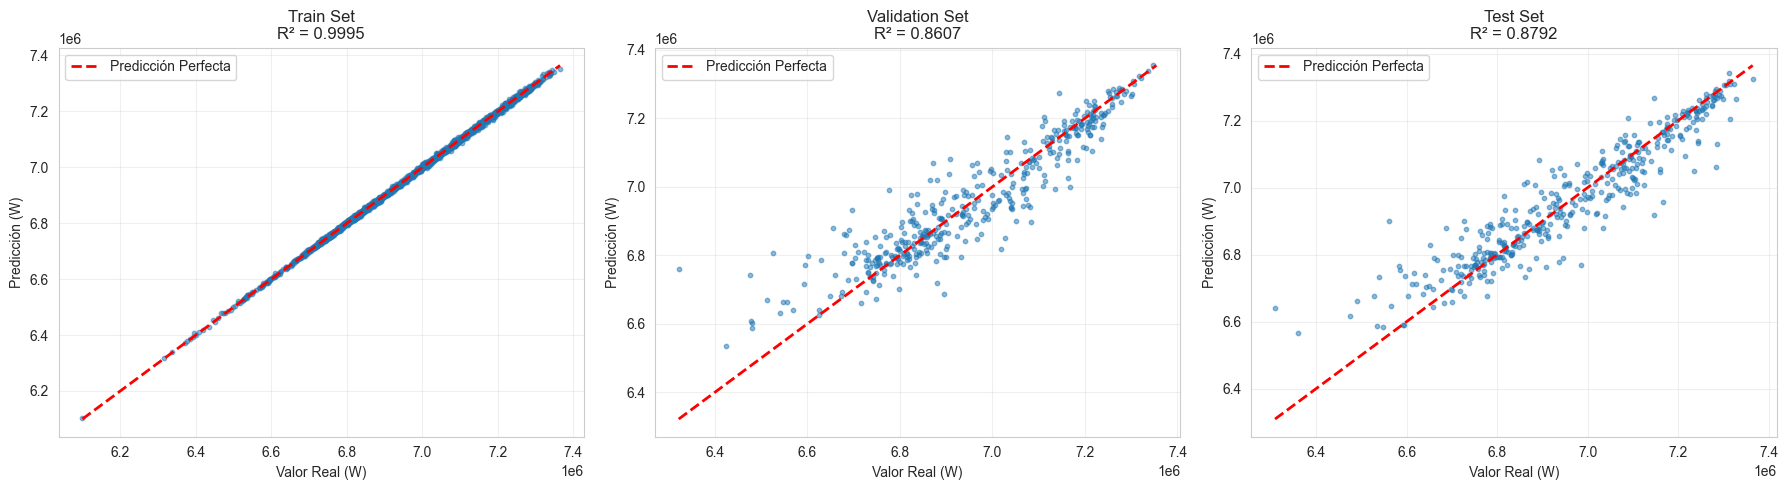

In [ ]:
# Predicciones vs Valores Reales
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sets = [
 (y_train, y_pred_train, 'Train', axes[0]),
 (y_val, y_pred_val, 'Validation', axes[1]),
 (y_test, y_pred_test, 'Test', axes[2])
]

for y_true, y_pred, name, ax in sets:
 ax.scatter(y_true, y_pred, alpha=0.5, s=10)
 
 # Línea perfecta (y=x)
 min_val = min(y_true.min(), y_pred.min())
 max_val = max(y_true.max(), y_pred.max())
 ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción Perfecta')
 
 ax.set_xlabel('Valor Real (W)')
 ax.set_ylabel('Predicción (W)')
 ax.set_title(f'{name} Set\nR² = {r2_score(y_true, y_pred):.4f}')
 ax.legend()
 ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 7. Importancia de Características


Top 20 Características Más Importantes:
              feature  importance
         max_distance    0.114687
mean_dist_neighbor_94    0.073905
mean_dist_neighbor_93    0.072233
mean_dist_neighbor_12    0.057448
         std_distance    0.020239
         min_distance    0.015480
          Y98_ordered    0.012226
          X81_ordered    0.011392
          X76_ordered    0.010587
          X77_ordered    0.010418
 min_dist_neighbor_95    0.010225
           Y3_ordered    0.008644
 min_dist_neighbor_48    0.008574
        mean_distance    0.008338
 mean_dist_neighbor_8    0.007819
          X96_ordered    0.006772
 min_dist_neighbor_96    0.006730
         Y100_ordered    0.006684
 mean_dist_neighbor_4    0.006522
         X100_ordered    0.006367


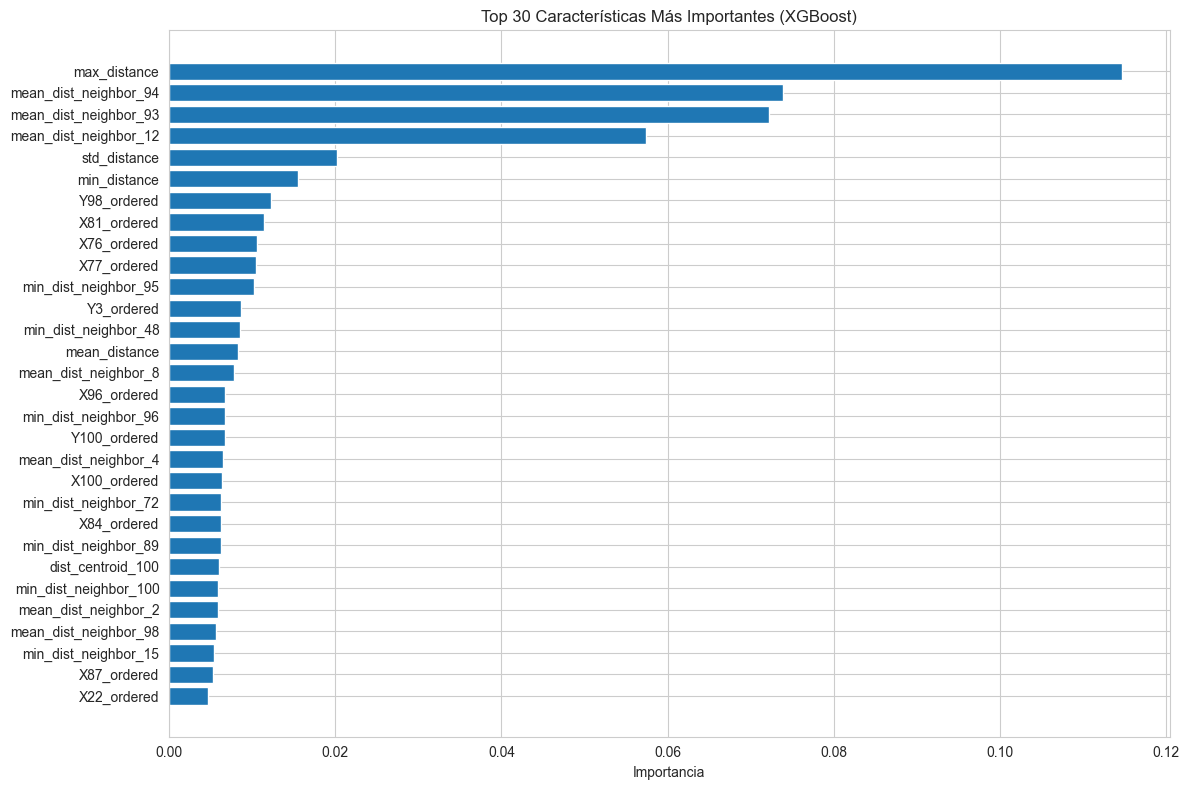

In [ ]:
# Importancia de características (feature importance)
feature_importance = best_model.feature_importances_
importance_df = pd.DataFrame({
 'feature': feature_names,
 'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Características Más Importantes:")
print(importance_df.head(20).to_string(index=False))

# Visualización
plt.figure(figsize=(12, 8))
top_n = 30
top_features = importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'].values)
plt.yticks(range(len(top_features)), top_features['feature'].values)
plt.xlabel('Importancia')
plt.title(f'Top {top_n} Características Más Importantes (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


## 8. Guardar Modelo


In [ ]:
# Guardar modelo, scaler y metadata
model_data = {
 'model': best_model,
 'scaler': scaler,
 'feature_names': feature_names,
 'n_converters': N_CONVERTERS,
 'dataset_name': DATASET_NAME,
 'metrics': {
 'train': metrics_train,
 'val': metrics_val,
 'test': metrics_test
 },
 'best_params': xgb_model.best_params_,
 'timestamp': datetime.now().isoformat()
}

model_file = MODELS_DIR / f"modelo_xgboost_{DATASET_NAME}.pkl"
with open(model_file, 'wb') as f:
 pickle.dump(model_data, f)

print(f"Modelo guardado en: {model_file}")
print(f"Resumen:")
print(f"Dataset: {DATASET_NAME}")
print(f"Convertidores: {N_CONVERTERS}")
print(f"Features: {len(feature_names)}")
print(f"RMSE (test): {metrics_test['RMSE']:.2f} W")
print(f"R² (test): {metrics_test['R2']:.4f}")


Modelo guardado en: models\modelo_xgboost_perth_100.pkl
Resumen:
Dataset: perth_100
Convertidores: 100
Features: 504
RMSE (test): 70794.93 W
R² (test): 0.8792
